# AI Image Caption BOT

### steps
- Data Collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing -- Images
- Data Preprocessing -- Captions
- Data Preprocessing using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle


In [3]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add

In [4]:
# Read text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()

    return captions

In [5]:
captions = readTextFile(r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt")
captions= captions.split("\n")[:-1] 

In [6]:
print(len(captions))

40460


In [7]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [8]:
first, second = captions[0].split('\t')
print(first.split('.'))
print(first.split('.')[0])
print(second)

['1000268201_693b08cb0e', 'jpg#0']
1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [9]:
# Dictionary to map each image with the list of captions it has
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0] 

    # if the image id is already present or not
    if descriptions.get(img_name) is None: 
        descriptions[img_name] = []

    descriptions[img_name].append(second)

In [10]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
import os
IMG_PATH = r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Images"

print(os.path.exists(IMG_PATH + "\\1000268201_693b08cb0e.jpg"))


True


In [12]:
print(IMG_PATH + "\\1000268201_693b08cb0e.jpg")


C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Images\1000268201_693b08cb0e.jpg


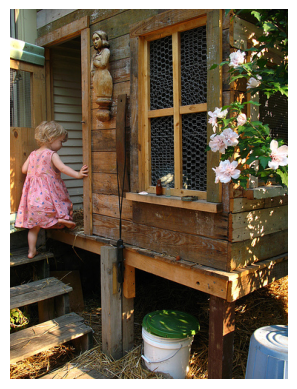

In [13]:
import cv2
img = cv2.imread(IMG_PATH + "\\1000268201_693b08cb0e.jpg")
if img is None:
    print("Image not found or path is incorrect!")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Data Cleaning

In [14]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s)>1] 
    sentence = " ".join(sentence)
    return sentence

In [15]:
clean_text("A cat is sitting over the house number #64")

'cat is sitting over the house number'

In [16]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [17]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [18]:
# Write the data to text file
with open("descriptions.txt", 'w') as f:
    f.write(str(descriptions))

# Vocabulary

In [19]:
descriptions = None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [20]:
print(type(descriptions))

<class 'dict'>


In [21]:
#Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size: %d" %len(vocab))

Vocab Size: 8424


In [22]:
a = ("apple","apple","banana")
set(a)

{'apple', 'banana'}

In [23]:
vocab

{'grazes',
 'peterson',
 'cycle',
 'clearing',
 'plate',
 'body',
 'assistance',
 'pale',
 'flirts',
 'over',
 'razer',
 'fairy',
 'scarfs',
 'most',
 'waving',
 'attack',
 'oxford',
 'plow',
 'games',
 'cappedhills',
 'pickup',
 'jumpropes',
 'exhibt',
 'neckless',
 'forelegs',
 'grainy',
 'fist',
 'liking',
 'tell',
 'shipping',
 'canada',
 'pillared',
 'carried',
 'untangles',
 'medatative',
 'waterbed',
 'wakeboarding',
 'pensively',
 'hurridly',
 'minimal',
 'several',
 'encounters',
 'restrain',
 'lunches',
 'greenery',
 'notepad',
 'spiking',
 'orchestra',
 'facility',
 'blond',
 'piste',
 'lot',
 'observe',
 'lightsaber',
 'cheery',
 'mat',
 'potties',
 'equipment',
 'groucho',
 'wheelers',
 'hardwood',
 'ratty',
 'traditional',
 'receiver',
 'lead',
 'scouts',
 'hits',
 'attend',
 'wrecked',
 'secret',
 'responding',
 'togerther',
 'scoop',
 'outfir',
 'shadows',
 'soup',
 'hung',
 'zagging',
 'bandanas',
 'exiting',
 'deciding',
 'herd',
 'khaki',
 'drap',
 'collected',
 'cre

In [24]:
#  Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
  
print("Total words %d"%len(total_words))

Total words 373837


In [25]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [26]:
# filter words from the Vocab according to certain threshold frequency

In [27]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [28]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True,key=lambda x:x[1])

#filter
threshold = 10
sorted_freq_cnt= [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [29]:
print(len(total_words))

1845


# Prepare Train and Test

In [30]:
train_file_data = readTextFile(r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt")


In [31]:
test_file_data = readTextFile(r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt")

In [32]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:10])

test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [33]:
# Prepare Description for the Training Data
#  Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [34]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images --> Features
- Text --> Features

# 1 Image Feature Extraction

In [35]:
model = ResNet50(weights="imagenet", input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [36]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [37]:
from keras.models import Model

In [38]:
model_new = Model(model.input,model.layers[-2].output) 

In [39]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np

def preprocess_img(img):
    img = load_img(img, target_size=(224, 224))  # Load and resize image
    img = img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    # Normalization 
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


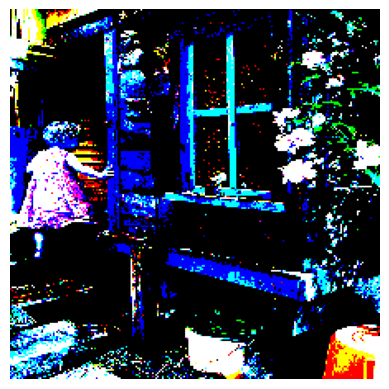

In [40]:
img = preprocess_img(IMG_PATH + "\\1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [41]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    # Converting from 2 axis to 1
    print(feature_vector.shape)
    return feature_vector

In [42]:
encode_image(IMG_PATH + "\\1000268201_693b08cb0e.jpg")

1/1 [==============================] - 2s 2s/step
(2048,)


array([0.06536547, 0.1678271 , 0.32518455, ..., 0.05111531, 0.32817906,
       1.0043341 ], dtype=float32)

In [43]:
# start = time()
# encoding_train={}
# # image_id --> feature vector extracted from Resnet Image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH + "/"+img_id+".jpg" 
#     encoding_train[img_id]= encode_image(img_path)

#     if ix%100==0:
#         print("Test encoding in progress time step%d" %ix)
# end_t = time()
# print("Total time taken(train):", end_t-start)

In [44]:
# # Store everything to the disk
# with open("encoded_train_features.pkl","wb") as f:
#     pickle.dump(encoding_train, f)  

In [45]:
start = time()
encoding_test={}
# image_id --> feature vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH + "/"+img_id+".jpg" 
    encoding_test[img_id]= encode_image(img_path)

    if ix%100==0:
        print("Test encoding in progress time step%d" %ix)
end_t = time()
print("Total time taken(test):", end_t-start)

1/1 [==============================] - 0s 246ms/step
(2048,)
Test encoding in progress time step0
1/1 [==============================] - 0s 251ms/step
(2048,)
1/1 [==============================] - 0s 225ms/step
(2048,)
1/1 [==============================] - 0s 211ms/step
(2048,)
1/1 [==============================] - 0s 223ms/step
(2048,)
1/1 [==============================] - 0s 210ms/step
(2048,)
1/1 [==============================] - 0s 217ms/step
(2048,)
1/1 [==============================] - 0s 212ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 215ms/step
(2048,)
1/1 [==============================] - 0s 210ms/step
(2048,)
1/1 [==============================] - 0s 192ms/step
(2048,)
1/1 [==============================] - 0s 249ms/step
(2048,)
1/1 [==============================] - 0s 299ms/step
(2048,)
1/1 [==============================] - 0s 317ms/step
(2048,)
1/1 [==============================] - 0s 252ms/

In [46]:
# Store everything to the disk
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test, f)  


# Data pre-processing for captions

In [47]:
#vocab
len(total_words)


1845

In [48]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1] = word



In [49]:
print(word_to_idx["dog"])
print(idx_to_word[6])


6
dog


In [50]:
print(len(idx_to_word))

1845


In [51]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size", vocab_size)

Vocab Size 1848


In [52]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))

print(max_len)

35


In [53]:
with open("word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)

In [54]:
with open("idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Loader (Generator)

In [55]:
def data_generator(train_descriptons, encoding_train, word_to_idx, max_len, batch_size):
    X1,X2, y = [],[],[]
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    #0 denotes padding word
                    xi = pad_sequences([xi],maxlen = max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi],num_classes= vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n == batch_size:
                    yield[[np.array(X1), np.array(X2)], np.array(y)]

                    X1,X2,y =[],[],[]
                    n = 0
                    
                
                

In [56]:
embedding_index = {}

# Open the file with the correct encoding
with open(r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\glove.6B.50d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        word_embedding = np.array(values[1:], dtype='float')
        embedding_index[word] = word_embedding

In [57]:
f.close()

In [58]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [59]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix
            

In [60]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architechture

In [61]:
# Image feature extractor model
input_img_features = Input(shape=(2048,)) 
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)


In [62]:
# Captions as Input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
imp_cap3 = LSTM(256)(inp_cap2)

In [63]:
from tensorflow.keras.layers import Add

decoder1 = Add()([inp_img2, imp_cap3])

In [64]:
# decoder1 = Add([inp_img2,imp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


In [65]:
model= Model(inputs = [input_img_features, input_captions], outputs = outputs)


In [66]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [67]:
# Embedding layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [69]:
# Training of Model

In [70]:
epochs = 20
batch_size = 3
steps= len(train_descriptions)//batch_size  

In [71]:
# # Synchronize keys
# common_keys = set(train_descriptions.keys()).intersection(set(encoding_train.keys()))
# train_descriptions = {key: train_descriptions[key] for key in common_keys}
# encoding_train = {key: encoding_train[key] for key in common_keys}

# # Training loop
# for i in range(epochs):
#     generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('./model_weights/model_' + str(i) + '.h5')


#### it took 18 Hours

In [72]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\model_9.h5")

# Predictions

In [73]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 32ms/step
dog is running on the snow


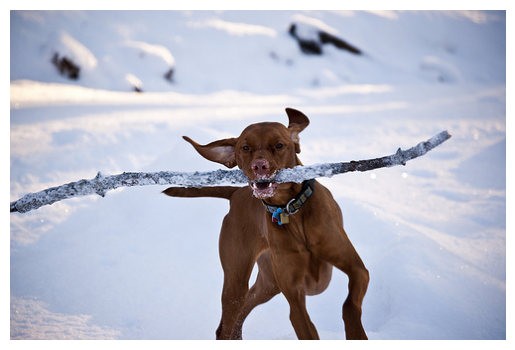

1/1 [==============================] - 0s 64ms/step
boy wearing helmet and helmet is riding unicycle on the street


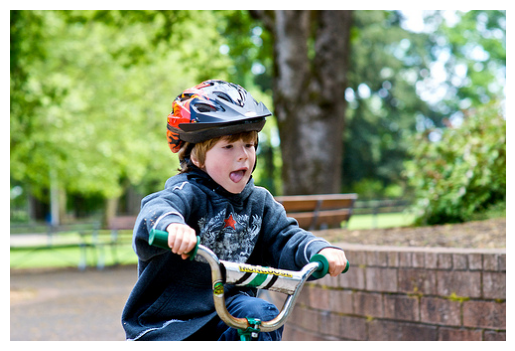

1/1 [==============================] - 0s 47ms/step
man and woman sit on bench


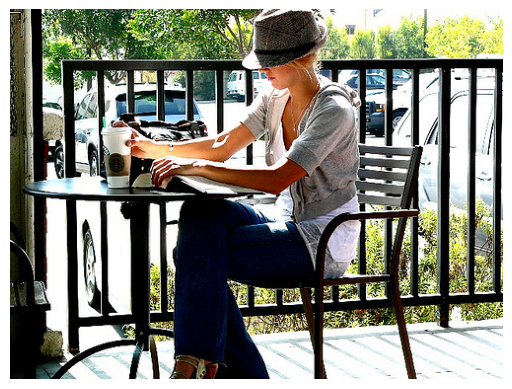

1/1 [==============================] - 0s 54ms/step
girl in white shirt is walking in the beach


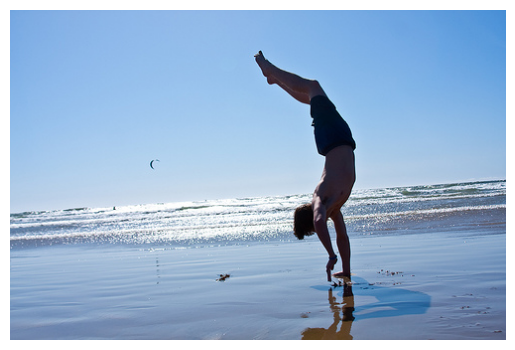

1/1 [==============================] - 0s 41ms/step
person climbs rock face


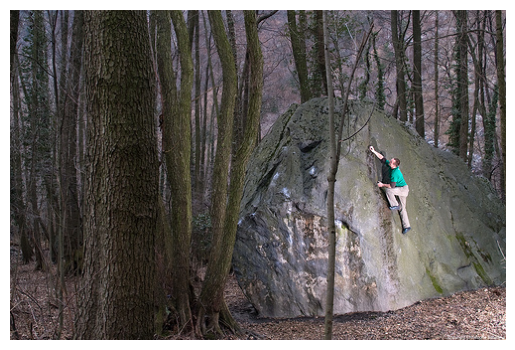

1/1 [==============================] - 0s 68ms/step
boy in blue shirt and cast shoes is sitting on bench


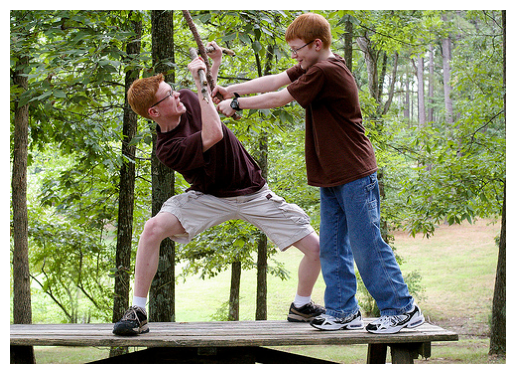

1/1 [==============================] - 0s 44ms/step
boy in plaid shirt and sandals is on tree stump


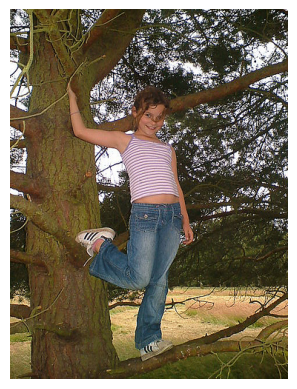

1/1 [==============================] - 0s 25ms/step
man in bathing suit is jumping into lake


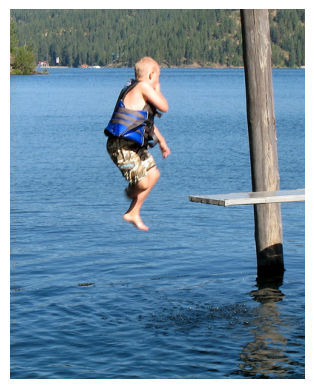

1/1 [==============================] - 0s 34ms/step
little boy in blue shirt is sitting in the bathroom


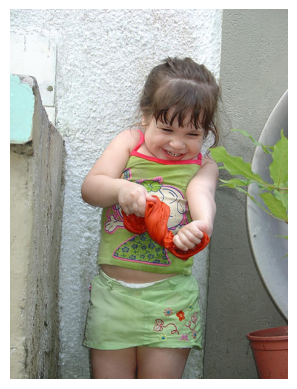

1/1 [==============================] - 0s 44ms/step
man in blue shirt and black helmet riding bicycle


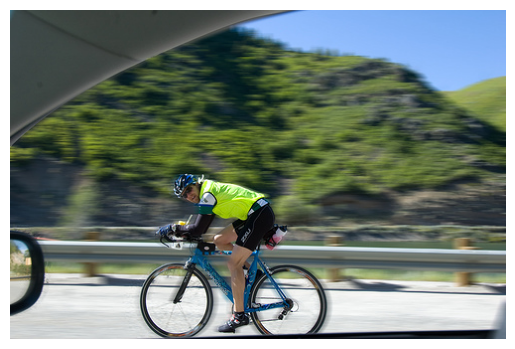

1/1 [==============================] - 0s 44ms/step
man rows boat in the water


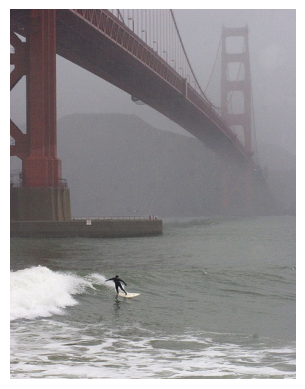

1/1 [==============================] - 0s 70ms/step
woman with long hair and glasses is wearing black hat


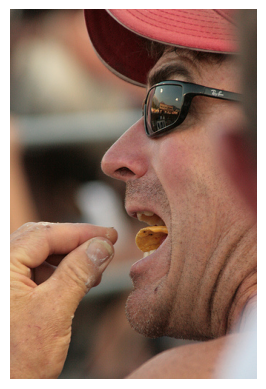

1/1 [==============================] - 0s 48ms/step
woman in red shirt and black shirt is holding up woman in black shirt


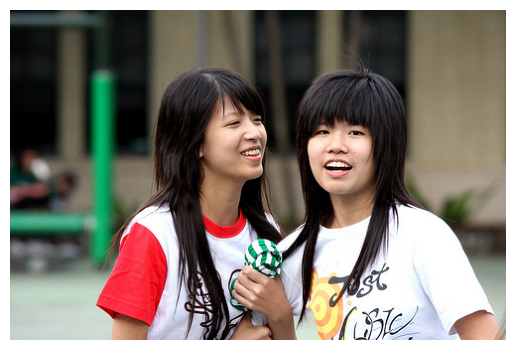

1/1 [==============================] - 0s 66ms/step
group of people are standing in front of some adults


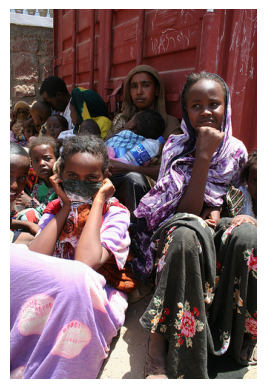

1/1 [==============================] - 0s 63ms/step
man in red and white coat is standing in the snow


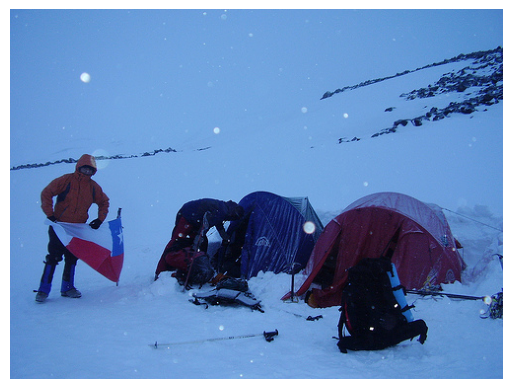

In [74]:
import matplotlib.pyplot as plt

for i in range(15):
    # Get the total number of items in encoding_test
    total_images = len(encoding_test)
    
    # Generate a random index within the valid range
    idx = np.random.randint(0, total_images)
    
    # Get the list of image names
    all_img_names = list(encoding_test.keys())
    
    # Get the image name using the random index
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1, 2048))

    # Corrected file path
    image_path = r"C:\Users\HP\Desktop\New folder\ML self learning projects\Deep learning projects\Flickr_Data\Flickr_Data\Images\\" + img_name + ".jpg"
    
    try:
        img = plt.imread(image_path)
        caption = predict_caption(photo_2048)
        print(caption)

        # plt.title(caption)
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {image_path}")
